In [1]:
import geopandas as gpd # for geospatial data handling
import pandas as pd
import osmnx as ox # for handling data from OpenStreetMap (osm) with the help of networkX (nx)
import contextily as cx # for plotting
import matplotlib.pyplot as plt # for plotting
from pyproj import CRS # for more advanced CRS modifications and transformations
from shapely.geometry import Polygon
import numpy as np
import pandana as pdna
import os
from tqdm import tqdm
import config as cfg
import networkx as nx

In [2]:
nombres_distritos = pd.read_csv(cfg.ZONIFICACION_DATA / 'distritos/PROCESSED_nombres_distritos.csv')
madrid_city_gdf = gpd.read_file(cfg.ZONIFICACION_DATA / 'distritos/madrid_gdf.geojson') # building a gdf containing only districts in the city of Madrid

In [3]:
madrid_city_gdf.to_crs(epsg=4326, inplace=True)  # Set CRS to WGS84 (latitude/longitude)

In [4]:
place = 'Madrid, Spain'
list_of_amenities = [ # amenities of interest to focus on
    "restaurant",
    "post_box",
    "pub",
    "atm",
    "townhall",
    "post_office",
    "kindergarten",
    "cinema",
    "cafe",
    "fire_station",
    "bank",
    "school",
    "place_of_worship",
    "childcare",
    "police",
    "pharmacy",
    "fast_food",
    "library",
    "clinic",
    "bar",
    "dentist",
    "theatre",
    "ice_cream",
    "doctors",
    "community_centre",
    "bureau_de_change",
    "veterinary",
    "arts_centre",
    "studio",
    "nightclub",
    "recycling",
    "marketplace",
    "college",
    "social_facility",
    "hospital",
    "social_centre",
    "university",
    "events_venue",
    "public_building"
]
tags = {'amenity': list_of_amenities}

walk_time = 15  # max walking horizon in minutes
walk_speed = 5  # km per hour
walk_time_sec = walk_time * 60 # We need the time in seconds to match how travel time is calculated in OSMnx

bike_time = 15  # max walking horizon in minutes
bike_speed = 15  # km per hour
bike_time_sec = bike_time * 60 # We need the time in seconds to match how travel time is calculated in OSMnx

drive_time = 15
drive_speed = 50
drive_time_sec = drive_time * 60

In [5]:
tags = {'amenity': list_of_amenities}  # Query all amenities
neighborhood_amenities_count = {}

# Loop through the neighborhoods by ID and geometry
for idx, (ID, polygon) in tqdm(madrid_city_gdf[['ID', 'geometry']].iterrows(), total=len(madrid_city_gdf)):
    try:
        # Query for amenities in the current neighborhood
        pois = ox.features_from_polygon(polygon, tags)
        
        # Count the number of amenities
        num_amenities = len(pois)
        
        # Store the result in a dictionary with ID as the key
        neighborhood_amenities_count[ID] = num_amenities
    
    except Exception as e:
        # Handle any errors (e.g., API issues or invalid geometries)
        print(f"Error processing neighborhood {ID}: {e}")

100%|██████████| 21/21 [00:04<00:00,  4.79it/s]


In [121]:
df_amenities_count = pd.DataFrame(list(neighborhood_amenities_count.items()), columns=['ID', 'num_amenities'])
# df_amenities_count.to_csv('amenities_by_district_count.csv', index=False)

In [133]:
madrid_city_gdf = madrid_city_gdf.to_crs(epsg=25830)  # Project to UTM for accurate area calculations
# Calculate the area in square meters (default output of GeoPandas for projected CRS)
madrid_city_gdf['area_sq_m'] = madrid_city_gdf.geometry.area
madrid_city_gdf['area_sq_km'] = (madrid_city_gdf['area_sq_m'] / 1e6).round(2)

In [144]:
df_amenities_count = pd.merge(df_amenities_count, madrid_city_gdf[['ID', 'area_sq_km']], on='ID', how='left')
df_amenities_count['amenity_density'] = (df_amenities_count['num_amenities']/ df_amenities_count['area_sq_km']).round(2)

In [145]:
df_amenities_count

,ID,num_amenities,area_sq_km,amenity_density
0,2807901,3489,5.21,669.67
1,2807902,810,6.56,123.48
2,2807903,608,5.37,113.22
3,2807904,1090,5.40,201.85
4,2807905,955,9.18,104.03
5,2807906,992,5.37,184.73
6,2807907,1401,4.68,299.36
7,2807908,1201,237.89,5.05
8,2807909,924,46.57,19.84
9,2807910,1107,25.43,43.53


In [146]:
df_amenities_count.to_csv('amenity_density_by_district.csv', index=False)

In [99]:
# RUN ONLY ONCE TO SAVE THE GRAPHS - ALREADY DONE
# FIXME: Not looping properly and names are not correct
walking_graphs = {}

# specify parameters for the analysis
walk_time = 15  # max walking horizon in minutes
walk_speed = 5  # km per hour
walk_time_sec = walk_time * 60 # We need the time in seconds to match how travel time is calculated in OSMnx

# Loop through the neighborhoods
for idx, (ID, polygon) in tqdm(madrid_city_gdf[['ID', 'geometry']].iterrows(), total=len(madrid_city_gdf)):
    try:
        # Create a walking graph for the current neighborhood (polygon)
        G_walk_neighborhood = ox.graph_from_polygon(polygon, network_type='walk')
        
        # Set walking speed and compute travel time for each edge
        for u, v, data in G_walk_neighborhood.edges(data=True):
            data['speed_kph'] = walk_speed  # Set speed for each edge
        
        # Add travel times to the graph
        G_walk_neighborhood = ox.add_edge_travel_times(G_walk_neighborhood)  # Calculate travel time in seconds
        
        # Save the graph to a file using the 'name' column for the filename
        ox.save_graphml(G_walk_neighborhood, f"/Users/caro/Desktop/thesis_project/amenities_analysis/walking_graphs/G_walk_{ID}.graphml")
        
        # Store the graph in the dictionary using the neighborhood name as the key
        walking_graphs[ID] = G_walk_neighborhood

    except Exception as e:
        # Handle any errors and print the issue
        print(f"Error processing {ID}: {e}")

100%|██████████| 21/21 [02:20<00:00,  6.71s/it]


In [103]:
# WALKING

amenities = ox.features_from_place(place, tags=tags)
amenities = amenities.to_crs('EPSG:25832') # ensuring amenities and OSMnx maps are on the same crs

# Dictionary to store centroids for each amenity
centroids_per_amenity = {}

# Loop through each amenity category
for amenity in list_of_amenities:
    # Filter amenities for the current category
    amenities_category = amenities[amenities['amenity'] == amenity]
    # Calculate centroids for the current category
    centroids_category = amenities_category.centroid
    # Store centroids for the current category in the dictionary
    centroids_per_amenity[amenity] = centroids_category

graphs_dir = '/Users/caro/Desktop/thesis_project/amenities_analysis/walking_graphs'

walking_graphs = {}
for file_name in tqdm(os.listdir(graphs_dir)):
    if file_name.endswith(".graphml"):
        neighborhood = file_name.replace("G_walk_", "").replace(".graphml", "")
        file_path = os.path.join(graphs_dir, file_name)
        G_walk_neighborhood = ox.load_graphml(file_path)
        walking_graphs[neighborhood] = G_walk_neighborhood
            

walk_pandanas = {}
# Build Pandana network for each neighborhood
for neighborhood, graph in tqdm(walking_graphs.items()):
    graph = ox.project_graph(graph, to_crs='EPSG:25832')
    nodes = ox.graph_to_gdfs(graph, edges=False)[['x', 'y']]
    edges = ox.graph_to_gdfs(graph, nodes=False).reset_index()[['u', 'v', 'travel_time']]
    
    network = pdna.Network(node_x=nodes['x'],
                            node_y=nodes['y'], 
                            edge_from=edges['u'],
                            edge_to=edges['v'],
                            edge_weights=edges[['travel_time']])
    
    walk_pandanas[neighborhood] = network


walking_distances = {}  # Initialize an empty dictionary to store distances for each amenity

for amenity in list_of_amenities:
    walking_distances[amenity] = {}

    for neighborhood, pandana in tqdm(walk_pandanas.items()):
        # Set points of interest (POIs) for the current amenity in the current neighborhood
        pandana.set_pois(category=amenity,  # Set the current amenity category dynamically
                        maxdist=walk_time_sec,
                        maxitems=3,
                        x_col=centroids_per_amenity[amenity].x,  # Use the centroid of the current amenity
                        y_col=centroids_per_amenity[amenity].y)
        
        # Find the nearest POIs for the current amenity in the current neighborhood
        distances = pandana.nearest_pois(distance=walk_time_sec,
                                        category=amenity,  # Set the current amenity category dynamically
                                        num_pois=3)
        
        # Convert travel time from seconds to minutes
        distances['travel_time'] = distances[1] / 60
        
        # Store the distances for the current amenity in the current neighborhood
        walking_distances[amenity][neighborhood] = distances

  5%|▍         | 1/21 [00:01<00:37,  1.86s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 7776
Setting CH edge vector of size 23538
Range graph removed 23728 edges of 47076
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 10%|▉         | 2/21 [00:03<00:37,  2.00s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 15160
Setting CH edge vector of size 45450
Range graph removed 46046 edges of 90900
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 14%|█▍        | 3/21 [00:05<00:28,  1.57s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 7996
Setting CH edge vector of size 23590
Range graph removed 23944 edges of 47180
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 19%|█▉        | 4/21 [00:07<00:30,  1.79s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 8129
Setting CH edge vector of size 25616
Range graph removed 25868 edges of 51232
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 24%|██▍       | 5/21 [00:07<00:20,  1.30s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 2878
Setting CH edge vector of size 8644
Range graph removed 8718 edges of 17288
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 29%|██▊       | 6/21 [00:09<00:23,  1.59s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 16360
Setting CH edge vector of size 48852
Range graph removed 49642 edges of 97704
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 33%|███▎      | 7/21 [00:11<00:23,  1.69s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 7799
Setting CH edge vector of size 21138
Range graph removed 21390 edges of 42276
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 38%|███▊      | 8/21 [00:12<00:17,  1.34s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 4007
Setting CH edge vector of size 12490
Range graph removed 12622 edges of 24980
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 43%|████▎     | 9/21 [00:13<00:14,  1.17s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 5470
Setting CH edge vector of size 16280
Range graph removed 16440 edges of 32560
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 48%|████▊     | 10/21 [00:13<00:11,  1.01s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 4532
Setting CH edge vector of size 13574
Range graph removed 13702 edges of 27148
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 52%|█████▏    | 11/21 [00:14<00:08,  1.18it/s]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 3653
Setting CH edge vector of size 10910
Range graph removed 11066 edges of 21820
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 57%|█████▋    | 12/21 [00:14<00:06,  1.41it/s]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 2625
Setting CH edge vector of size 8102
Range graph removed 8164 edges of 16204
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 62%|██████▏   | 13/21 [00:17<00:10,  1.33s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 13213
Setting CH edge vector of size 37936
Range graph removed 38294 edges of 75872
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 67%|██████▋   | 14/21 [00:18<00:08,  1.27s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 8598
Setting CH edge vector of size 24110
Range graph removed 24410 edges of 48220
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

 71%|███████▏  | 15/21 [00:19<00:07,  1.28s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 8621
Setting CH edge vector of size 25804
Range graph removed 26098 edges of 51608
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 76%|███████▌  | 16/21 [00:22<00:08,  1.70s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 13387
Setting CH edge vector of size 40346
Range graph removed 40764 edges of 80692
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 81%|████████  | 17/21 [00:23<00:05,  1.46s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 5804
Setting CH edge vector of size 18488
Range graph removed 18598 edges of 36976
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 86%|████████▌ | 18/21 [00:23<00:03,  1.14s/it]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 2640
Setting CH edge vector of size 8098
Range graph removed 8176 edges of 16196
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 90%|█████████ | 19/21 [00:24<00:01,  1.09it/s]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 3150
Setting CH edge vector of size 9344
Range graph removed 9498 edges of 18688
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 95%|█████████▌| 20/21 [00:25<00:00,  1.09it/s]

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 6698
Setting CH edge vector of size 20280
Range graph removed 20488 edges of 40560
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


100%|██████████| 21/21 [00:25<00:00,  1.22s/it]


Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 4625
Setting CH edge vector of size 14052
Range graph removed 14232 edges of 28104
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


100%|██████████| 21/21 [00:00<00:00, 42.98it/s]


In [104]:
dfs = []

# Iterate through each amenity and its corresponding DataFrame
for amenity, neighborhood_df_dict in walking_distances.items(): # CHANGE HERE
    # Iterate through each neighborhood DataFrame
    for neighborhood, df in neighborhood_df_dict.items():
        # Add a column for 'amenity' and 'neighborhood' to the DataFrame
        df['amenity'] = amenity
        df['neighborhood'] = neighborhood
        
        # Append the modified DataFrame to the list
        dfs.append(df)

# Concatenate all DataFrames in the list along the rows axis
combined_df = pd.concat(dfs, ignore_index=True)

In [112]:
combined_df.to_parquet('/Users/caro/Desktop/thesis_project/amenities_analysis/distances/walking_distances.parquet', index=False)  # Set index=False if you don't want to save the index. CHANGE HERE

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


In [107]:
# function for plotting
def plot_neighborhood_graph(transportation_type, neighbourhood, distances_by_transportation, amenity):
    
    # Load the appropriate graph based on the transportation type
    if transportation_type == "walking":
        G = walking_graphs[neighbourhood]
    elif transportation_type == "driving": # FIXME: Complete 
        G = driving_graphs[neighbourhood]
    elif transportation_type == "biking": # FIXME: Complete 
        G = biking_graphs[neighbourhood]
    # CRS
    G_proj = ox.project_graph(G)
    
    distances = distances_by_transportation[amenity][neighbourhood]
    
    # Plot the graph with a light background
    fig, ax = ox.plot_graph(G_proj, figsize=(10, 8), bgcolor='white', edge_color='#CCCCCC', edge_linewidth=0.5, node_size=0, show=False, close=False)
    
    # Assuming 'nodes_anjou' is a DataFrame containing node positions and 'distances_anjou' contains the data to plot
    nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
    sc = ax.scatter(x=nodes_proj["x"], y=nodes_proj["y"], c=distances['travel_time'], s=30, cmap='inferno_r', alpha=0.8)
    plt.colorbar(sc, ax=ax, shrink=0.7)
    plt.show()

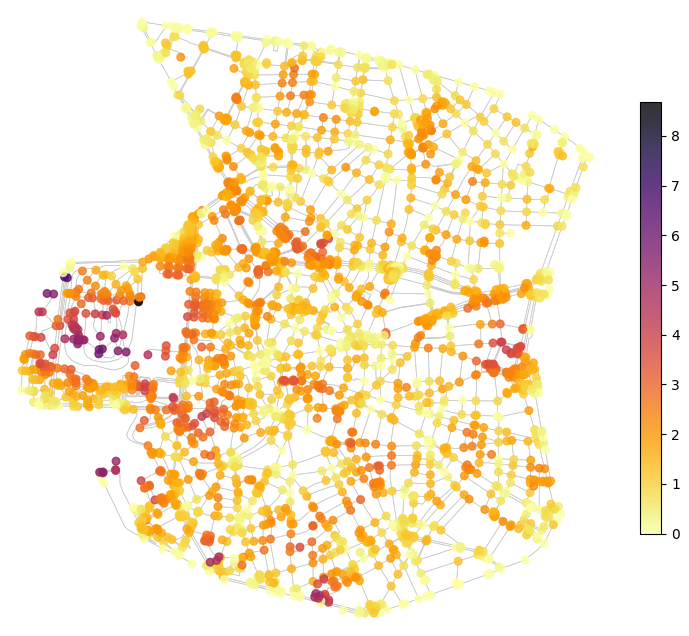

In [108]:
# example usage
plot_neighborhood_graph(transportation_type='walking',
                        neighbourhood='2807901',
                        distances_by_transportation=walking_distances,
                        amenity='pharmacy')

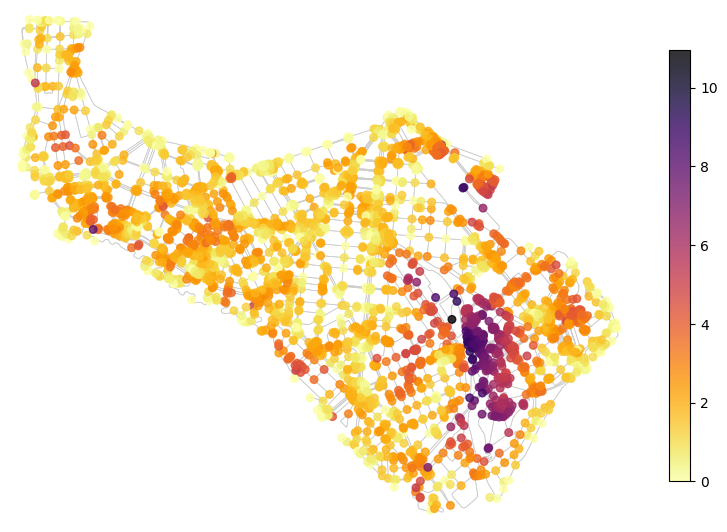

In [109]:
# example usage
plot_neighborhood_graph(transportation_type='walking',
                        neighbourhood='2807902',
                        distances_by_transportation=walking_distances,
                        amenity='pharmacy')

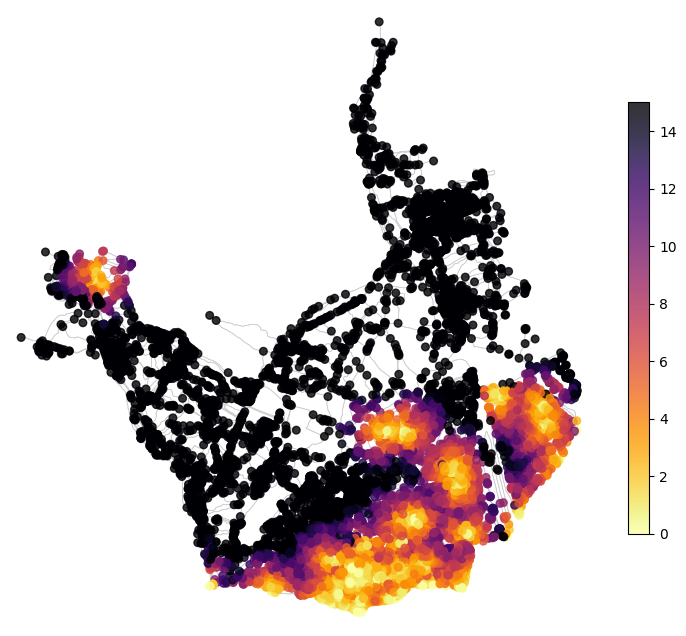

In [136]:
# example usage
plot_neighborhood_graph(transportation_type='walking',
                        neighbourhood='2807908',
                        distances_by_transportation=walking_distances,
                        amenity='bar')

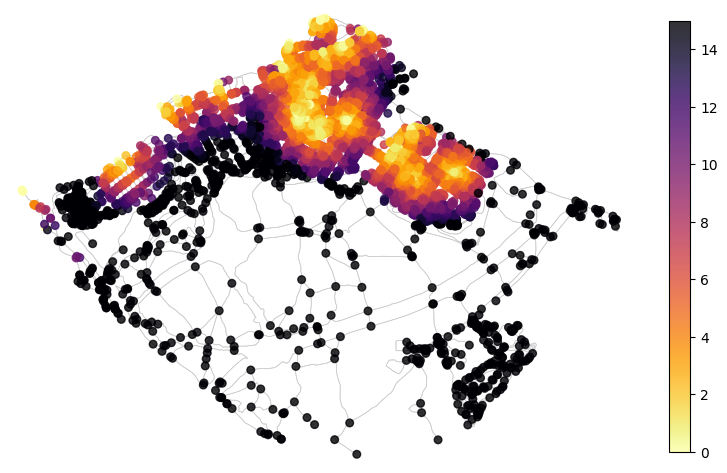

In [113]:
plot_neighborhood_graph(transportation_type='walking',
                        neighbourhood='2807918',
                        distances_by_transportation=walking_distances,
                        amenity='bar')

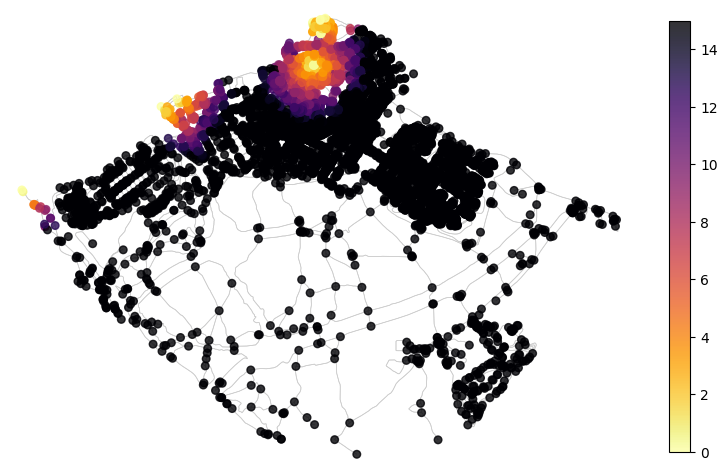

In [116]:
plot_neighborhood_graph(transportation_type='walking',
                        neighbourhood='2807918',
                        distances_by_transportation=walking_distances,
                        amenity='hospital')